In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

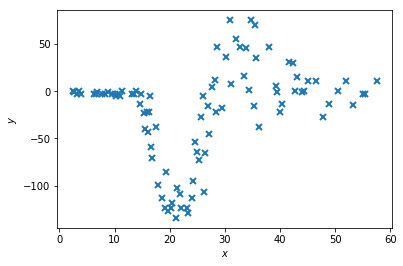

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = hetero_kernels.RBF(1)
k2 = hetero_kernels.RBF(1)
m = hetero_gpmc.GPMCHeteroNoiseRegression(Xnorm, Y[:,None], k1, k2)

In [4]:
m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance.prior = gpflow.priors.Gamma(3.,3.)

m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern2.variance.prior = gpflow.priors.Gamma(1.,1.)

m.kern2.variance = .1
m.kern2.variance.fixed = True

In [5]:
m.optimize(maxiter=1000) # start near MAP
samples = m.sample(3000, verbose=True, epsilon=0.01, thin = 2, burn = 500, Lmax = 20)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  98.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  99.0 %
Iteration:  500 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  98.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  98.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  98.0 %
Iteration:  700 	 Acc Rate:  99.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  98.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
Iteration:  1100 	 Acc Rate:  100.0 %
Iteration:  1200 	 Acc Rate:  100.0 %
Iteration:  1300 	 Acc Rate:  99.0 %
Iteration:  1400 	 Acc Rate:  100.0 %
Iteration:  1500 	 Acc Rate:  98.0 %
Iteration:  1600 	 Acc Rate:  100.0 %
Iteration:  1700 	 Acc Rate:  100.0 %
Iteration:  1800 	 Acc Rate:  100.0 %
Iteration:  1900 	 Acc Rate:  99.0 %
Iteration:  2000 	 Acc Rate:  99.0 %
Iteration:  2100 	 Acc Rate:  9

In [6]:
m

Name,values,prior,constraint
hetero_noise_regression_model.V1,[[-0.07083726] [-0.20583094] [ 0.06158749] [-0.07958483] [-0.21412199] [-0.2498866 ] [-0.05526334] [ 0.24082641] [ 0.26223875] [ 0.35708087] [ 0.06442986] [-0.24510782] [-0.77855829] [-0.64867463] [-1.11133755] [-1.44051225] [-1.66585529] [-3.27964515] [-3.61622102] [-2.36363 ] [-3.18970404] [-2.39907497] [-2.50439084] [-1.91714932] [-1.58603228] [-1.25794898] [-1.2757824 ] [-1.34975162] [-1.30152256] [-1.16424397] [-1.68161185] [-1.21080712] [-1.27421839] [-1.06387464] [-0.44197816] [-0.39215762] [-0.39743922] [-0.15717779] [-0.09208972] [ 0.12348389] [ 0.17026899] [ 0.20209469] [ 0.54093419] [ 0.61543581] [ 0.55003945] [ 0.60951452] [ 0.60993516] [ 0.60761625] [ 0.67340266] [ 0.45143746] [ 0.58707065] [ 0.42135947] [ 0.45577867] [ 0.60725315] [ 0.41577004] [ 0.48191355] [ 0.47352381] [ 0.30456253] [ 0.26024223] [ 0.32558781] [ 0.27217452] [ 0.13621907] [ 0.03633349] [ 0.02027866] [-0.00837181] [ 0.01863051] [ 0.06141047] [ 0.11514409] [ 0.18004048] [ 0.19768931] [ 0.17659418] [ 0.19517984] [ 0.29349282] [ 0.43418488] [ 0.26509553] [-0.06799604] [-0.16978482] [-0.33897361] [-0.40859533] [-0.4590144 ] [-0.2503092 ] [-0.07112397] [-0.02758849] [ 0.11026172] [ 0.13415683] [ 0.11630472] [-0.18182643] [-0.46622011] [-0.31647066] [ 0.33134835] [ 0.79316422] [ 0.72951268] [ 0.3038894 ] [ 0.09280327]],"N([ 0.],[ 1.])",(none)
hetero_noise_regression_model.V2,[[ 2.54114330e+00] [ 5.70803305e+00] [ 2.65166316e+00] [ 1.40207749e+00] [ 1.93480686e+00] [ 5.12140002e+00] [ 1.32547719e+00] [ 1.01604765e+00] [ 2.22712226e+00] [ 1.38354080e+00] [ 1.45923501e+00] [ 1.69767833e+00] [ 1.26551590e+00] [ 9.50456502e-01] [ 1.11403993e+00] [ 1.19744263e+00] [ 1.20485009e+00] [ 2.14069770e+00] [ 8.81848465e-01] [ 5.90875301e-01] [ 9.10736425e-01] [ 6.42746889e-01] [ 8.11371365e-01] [ 6.21185577e-01] [ 5.42670503e-01] [ 5.09330322e-01] [ 4.95852793e-01] [ 4.96133571e-01] [ 4.86166287e-01] [ 4.86506699e-01] [ 8.19590837e-01] [ 6.06384516e-01] [ 7.77313595e-01] [ 6.90325572e-01] [ 4.68355156e-01] [ 3.88309871e-01] [ 5.03225975e-01] [ 4.03053786e-01] [ 5.78609876e-01] [ 4.14472113e-01] [ 4.11970140e-01] [ 3.42184437e-01] [ 6.07539364e-01] [ 3.71396206e-01] [ 3.90096806e-01] [ 2.88784670e-01] [ 2.94948294e-01] [ 2.98119648e-01] [ 2.98526705e-01] [ 2.49448116e-01] [ 2.69963800e-01] [ 2.37253502e-01] [ 2.10934576e-01] [ 2.81165841e-01] [ 2.31264395e-01] [ 2.40215333e-01] [ 2.73552356e-01] [ 2.09204931e-01] [ 1.79322215e-01] [ 2.47310989e-01] [ 2.61638209e-01] [ 2.43678623e-01] [ 1.51304958e-01] [ 1.82084490e-01] [ 1.84324752e-01] [ 1.55681181e-01] [ 1.24510813e-01] [ 1.26089704e-01] [ 1.10542997e-01] [ 9.72804109e-02] [ 7.96073183e-02] [ 6.60455439e-02] [ 8.83363810e-02] [ 1.41923174e-01] [ 9.19466578e-02] [ 4.51208657e-02] [ 4.56930554e-02] [ 3.80501944e-02] [ 5.34781868e-02] [ 4.14726496e-02] [ 2.62227733e-02] [ 1.85976057e-02] [ 2.41918607e-02] [ 1.72486304e-02] [ 1.55062483e-02] [ 1.75436877e-02] [ 1.09044051e-02] [ 1.75387160e-03] [ -5.04518847e-04] [ 7.48450143e-04] [ -3.33916941e-03] [ -5.66087345e-03] [ -1.97853763e-03] [ -9.75007079e-04]],"N([ 0.],[ 1.])",(none)
hetero_noise_regression_model.kern1.lengthscales,[ 0.24563116],"Ga([ 1.],[ 1.])",+ve
hetero_noise_regression_model.kern1.variance,[ 138.77474163],"Ga([ 3.],[ 3.])",+ve
hetero_noise_regression_model.kern2.lengthscales,[ 1.33994623],"Ga([ 1.],[ 1.])",+ve
hetero_noise_regression_model.kern2.variance,[ 0.1],None,[FIXED]


In [7]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv
meanmat1 = np.zeros(shape = (samples.shape[0], xx.shape[0]))
varmat1 = np.zeros(shape = (samples.shape[0], xx.shape[0]))
meanmat2 = np.zeros(shape = (samples.shape[0], xx.shape[0]))
varmat2 = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [8]:
sample_df = m.get_samples_df(samples)

In [9]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:]
    meanmat1[i,:] = mean1[:,0]
    varmat1[i,:] = np.diag(var1)
    mean2, v2 = m.predict_n(xx)
    var2 = v2[:,:]
    meanmat2[i,:] = mean2[:,0]
    varmat2[i,:] = np.diag(var2)

In [10]:
m1 = meanmat1[0,:]
v1 = varmat1[0,:]
std1 = np.sqrt(v1)
m2 = meanmat2[0,:]
v2 = varmat2[0,:]
std2 = np.sqrt(v2)

In [23]:
def visualize(Xgrid, M1, V1, M2, V2):
    """
    Visualize
    """
    Std1 = np.sqrt(V1)
    Std2 = np.sqrt(V2)
    
    L1 = M1 - 2*Std1
    U1 = M1 + 2*Std1
    
    
    N = M2 + 2*Std2
    Nexp = np.exp(N)
    
    L2 = L1 - 2*Nexp
    U2 = U1 + 2*Nexp
    
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, M1, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L1, U1,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], L2, U2,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

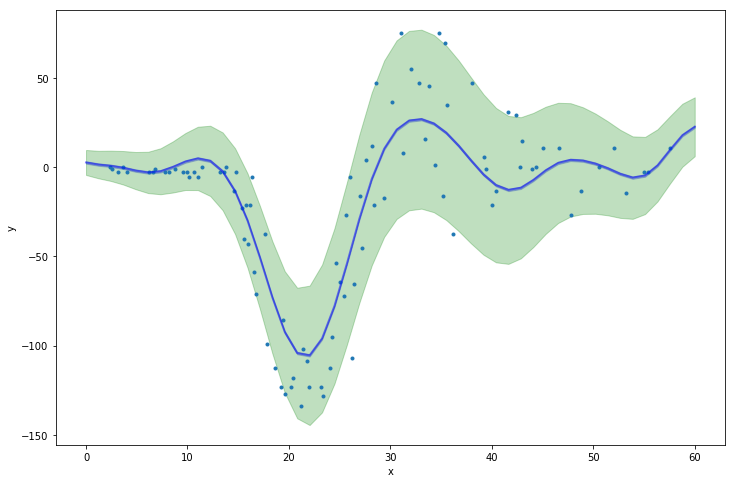

In [29]:
mini = 205
maxi = 206
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, meanmat1[i,:], varmat1[i,:], meanmat2[i,:], varmat2[i,:])

In [11]:
# Data generation scheme (posterior predictive distribution)
S1 = np.random.normal(m1, std1)
S2 = np.random.normal(m2, std2)
S2exp = np.exp(S2)

P = np.random.normal(S1, S2exp)

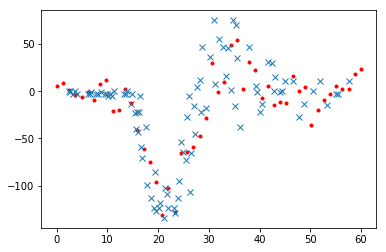

In [12]:
plt.plot(xnew, P, '.', color = 'r')
plt.plot(X, Y, 'x')

In [13]:
m1

array([  7.00703487,   3.63671019,   0.37692716,  -1.53927801,
        -2.18788511,  -2.27904592,  -2.56682264,  -3.66169925,
        -5.66358678,  -7.99440381, -10.27131546, -13.56981495,
       -20.38361153, -32.83112511, -50.56893194, -70.23687058,
       -86.94763665, -96.65360254, -97.56782728, -89.90213609,
       -75.0052616 , -55.16939461, -33.61939131, -13.5334751 ,
         3.26562905,  16.27889622,  25.10716228,  28.86755146,
        27.01862895,  20.49249073,  11.83796984,   4.19025267,
        -0.12158951,  -0.39058302,   2.49056341,   6.57553656,
         9.66902847,  10.17622236,   7.64385357,   2.8620032 ,
        -2.36335092,  -5.90242378,  -6.49550933,  -4.60850923,
        -1.85560294,   0.7246446 ,   3.69691866,   8.24291918,
        14.21363602,  19.54643313])

In [14]:
S2exp

array([  3.74170609,   4.09046226,   4.48041139,   4.94783891,
         5.44599648,   6.03886821,   6.71694175,   7.47670631,
         8.31815956,   9.25104559,  10.30275027,  11.40348013,
        12.60736635,  13.8911809 ,  15.24824728,  16.68028523,
        18.16014044,  19.62200384,  20.98522331,  22.37066385,
        23.58112382,  24.60731245,  25.53029164,  26.27153518,
        26.66870419,  27.01154865,  26.96878262,  26.79428686,
        26.29411528,  25.59785919,  24.72234459,  23.69933963,
        22.57115814,  21.29096607,  20.0183269 ,  18.63576072,
        17.28536382,  16.00462303,  14.6723891 ,  13.47461357,
        12.29784388,  11.19626631,  10.19234272,   9.21738598,
         8.32377839,   7.56242813,   6.84152569,   6.17882682,
         5.59519329,   5.0715696 ])

In [15]:
m

Name,values,prior,constraint
hetero_noise_regression_model.V1,[[ -9.38121943e-02] [ -4.17588224e-01] [ 1.87966720e-01] [ -1.32172624e-04] [ 1.86466768e-01] [ -7.78666232e-01] [ -9.29049187e-01] [ 4.94958552e-01] [ 3.50254151e-01] [ 1.27594819e+00] [ 7.52890441e-01] [ -1.85741375e+00] [ -1.29461651e+00] [ 1.30175876e-02] [ 9.10033882e-02] [ -2.00023486e+00] [ -7.67593624e-01] [ -4.59791572e+00] [ -3.56254240e+00] [ -1.11971362e+00] [ -2.41097730e+00] [ -1.91512682e+00] [ -1.99541472e+00] [ -1.05349716e+00] [ -2.90734335e+00] [ -2.48208326e+00] [ -6.47727790e-01] [ -1.54159385e+00] [ 3.63826923e-01] [ -1.65806784e+00] [ -2.69314157e+00] [ 7.41516858e-02] [ -1.18223376e+00] [ -1.62569088e+00] [ -1.60629461e+00] [ 5.63466353e-02] [ 9.88021843e-02] [ -6.80038991e-02] [ -6.50737184e-01] [ -1.17830539e+00] [ 9.78166503e-01] [ -4.67909157e-01] [ -6.00239803e-01] [ 2.53899044e+00] [ 5.37198473e-01] [ 5.77714245e-01] [ -1.28234242e+00] [ 9.37849859e-01] [ 1.32461221e+00] [ -8.12174805e-01] [ 2.16788821e+00] [ 2.27628262e-01] [ -1.32888647e-01] [ 2.01135436e+00] [ 3.83571948e-01] [ -4.07348049e-02] [ -1.42242884e-01] [ 1.61687692e+00] [ -3.02323781e-01] [ 7.20906066e-01] [ 8.81285795e-01] [ -7.87483907e-01] [ 1.96009339e-02] [ 9.90472221e-01] [ 1.13161357e+00] [ -1.48433359e+00] [ -2.60516641e-01] [ 1.23638574e+00] [ -1.33958366e-02] [ 1.43284225e+00] [ -1.04562335e+00] [ 2.78754358e+00] [ -1.33588554e+00] [ -2.33329339e-01] [ -9.64370177e-02] [ 1.25693652e-01] [ 1.05656750e+00] [ -1.28705272e+00] [ -1.08637581e+00] [ -5.90443777e-01] [ -1.08070415e+00] [ -1.30991836e+00] [ -1.88920136e+00] [ 8.78012236e-01] [ 8.13500490e-01] [ -8.81138107e-01] [ 5.25967187e-01] [ -5.93538935e-01] [ 3.49128793e-01] [ -8.28743727e-01] [ -1.38389959e-01] [ 3.80322963e-01] [ 1.19944693e+00] [ 1.13838664e+00]],"N([ 0.],[ 1.])",(none)
hetero_noise_regression_model.V2,[[ 3.11641285e+00] [ 6.78295929e+00] [ 2.38263070e+00] [ 1.57963231e+00] [ -3.49006135e-01] [ 3.89941219e+00] [ 2.65689553e+00] [ 1.13800161e+00] [ 2.07558033e+00] [ 2.89159624e+00] [ 4.79852430e-01] [ 4.54495672e-01] [ 1.34076085e+00] [ -4.76639002e-01] [ 1.95101812e-02] [ 1.45496792e+00] [ 1.88187579e+00] [ 2.50762421e+00] [ 2.21897244e+00] [ 1.34144463e+00] [ 1.09377960e+00] [ 7.84375029e-01] [ 4.22511736e-01] [ 5.46222119e-01] [ 1.38001108e+00] [ 1.05936032e+00] [ 4.44410086e-01] [ -3.28441412e-01] [ -4.04548015e-01] [ 1.79643492e+00] [ -4.60187423e-01] [ 6.55583586e-01] [ 1.15265002e+00] [ 7.10071609e-01] [ 1.48269594e+00] [ 4.57792748e-01] [ 6.22218570e-01] [ -6.55464748e-01] [ 7.73660070e-01] [ 8.58988777e-01] [ 1.19209466e+00] [ -3.56741152e-02] [ 1.65151058e+00] [ -6.20824601e-01] [ 1.62636061e+00] [ -5.23848725e-01] [ 1.47721112e+00] [ -1.27769478e-01] [ 4.27065174e-01] [ -2.95735583e-01] [ 1.15227023e+00] [ 3.80103108e-01] [ 9.63806135e-01] [ 5.92991702e-01] [ 1.57139120e+00] [ -3.29628701e-01] [ 8.94105764e-01] [ 5.67961457e-01] [ -5.01164769e-01] [ 1.79424105e+00] [ 2.17321702e+00] [ 1.30560715e-03] [ -8.30654009e-01] [ 1.98382356e+00] [ 2.38620259e-01] [ 1.47774354e+00] [ -4.44600798e-01] [ -9.60438417e-01] [ -2.31989581e+00] [ 2.13071100e-01] [ 1.58404252e+00] [ -1.39292690e-02] [ 8.52942474e-01] [ 7.98391815e-02] [ -1.59660120e+00] [ -1.53042070e-02] [ 8.78113680e-01] [ 3.48425606e-01] [ 2.02128861e+00] [ -1.29379548e+00] [ -1.37317015e-01] [ 1.21821992e+00] [ 1.15154112e+00] [ -1.73727125e-01] [ -1.15234121e+00] [ 1.19257507e+00] [ -1.36846267e+00] [ 1.18555748e+00] [ -1.30093905e+00] [ 8.14027446e-01] [ -1.46327937e+00] [ -2.87560847e-01] [ 4.33028770e-01] [ -4.92151668e-01]],"N([ 0.],[ 1.])",(none)
hetero_noise_regression_model.kern1.lengthscales,[ 0.24589543],"Ga([ 1.],[ 1.])",+ve
hetero_noise_regression_model.kern1.variance,[ 139.02753903],"Ga([ 3.],[ 3.])",+ve
hetero_noise_regression_model.kern2.lengthscales,[ 1.39881225],"Ga([ 1.],[ 1.])",+ve
hetero_noise_regression_model.kern2.variance,[ 0.1],None,[FIXED]


In [18]:
m2

array([ 1.31854174,  1.40715725,  1.4999746 ,  1.59658311,  1.69649357,
        1.79914245,  1.90389779,  2.01006671,  2.11690432,  2.223624  ,
        2.32940868,  2.43342293,  2.5348256 ,  2.63278269,  2.72648007,
        2.81513591,  2.89801231,  2.97442605,  3.04375805,  3.10546151,
        3.15906836,  3.20419412,  3.24054098,  3.26789909,  3.28614627,
        3.29524604,  3.29524424,  3.2862644 ,  3.26850207,  3.24221833,
        3.20773271,  3.16541581,  3.11568184,  3.05898115,  2.99579323,
        2.92662   ,  2.85197974,  2.77240163,  2.68842097,  2.60057504,
        2.50939966,  2.41542628,  2.31917954,  2.22117531,  2.12191896,
        2.02190377,  1.92160951,  1.82150097,  1.72202638,  1.62361573])

In [19]:
std2

array([ 0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267,
        0.00153267,  0.00153267,  0.00153267,  0.00153267,  0.00153267])

In [20]:
lower = m2 - 2*std2
upper = m2 + 2*std2

L = np.exp(lower)
U = np.exp(upper)

In [21]:
L

array([  3.72652591,   4.0718275 ,   4.46785873,   4.92102957,
         5.43809182,   6.02596187,   6.69146249,   7.44097118,
         8.27996704,   9.21247617,  10.24042731,  11.36294469,
        12.57562314,  13.8698491 ,  15.23224769,  16.64434599,
        18.08254267,  19.51846056,  20.91972963,  22.25120516,
        23.47657284,  24.56023789,  25.46934684,  26.1757591 ,
        26.65777732,  26.90146399,  26.90141549,  26.66092647,
        26.19154731,  25.51210368,  24.64730027,  23.62606331,
        22.47978594,  21.24062914,  19.94000264,  18.60731284,
        17.26902454,  15.94804577,  14.66341527,  13.43025108,
        12.2599068 ,  11.16027883,  10.13621043,   9.18994527,
         8.32159236,   7.52957375,   6.81103558,   6.16221096,
         5.57872939,   5.0558723 ])

In [22]:
U

array([  3.74944218,   4.0968672 ,   4.49533382,   4.95129144,
         5.47153337,   6.06301852,   6.73261164,   7.48672943,
         8.33088469,   9.26912828,  10.30340081,  11.43282112,
        12.65295693,  13.95514173,  15.32591839,  16.74670038,
        18.19374126,  19.63848932,  21.0483755 ,  22.38803893,
        23.62094201,  24.71127106,  25.62597057,  26.33672691,
        26.82170931,  27.06689453,  27.06684572,  26.82487782,
        26.35261221,  25.66899034,  24.79886883,  23.77135177,
        22.61802537,  21.37124838,  20.06262367,  18.7217385 ,
        17.3752204 ,  16.04611826,  14.75358793,  13.5128404 ,
        12.33529909,  11.22890896,  10.19854305,   9.24645883,
         8.37276599,   7.57587686,   6.85292004,   6.20010547,
         5.61303578,   5.08696338])